# Quora Question-pair Problem


In [13]:
from time import time
import pandas as pd
import numpy as np

import spacy

from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint

from collections import Counter
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,precision_recall_curve

In [14]:
### Load spaCy's English NLP model
nlp = spacy.load('en_core_web_lg')

## 1. Read train and test csv file

In [4]:
%%time
print('Time taken to read the train data:')
train = pd.read_csv("train.csv", low_memory=False).fillna("")

Time taken to read the train data:
Wall time: 6.59 s


In [15]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
%%time
print('Time taken to read the test data:')
test = pd.read_csv("test.csv",low_memory=False).fillna("")

Time taken to read the test data:
Wall time: 48.2 s


In [16]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [17]:
train_df = pd.read_csv("train.csv", nrows=1000)

In [18]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(train_df, test_size=0.3, random_state=42 )

## 2. Exploratory Data Analysis

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [12]:
train.shape

(404290, 6)

In [13]:
test.shape

(3563475, 3)

In [14]:
"""Check for missing values:"""
print(train['question1'].str.isspace().sum())
print(train['question2'].str.isspace().sum())

0
0


Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



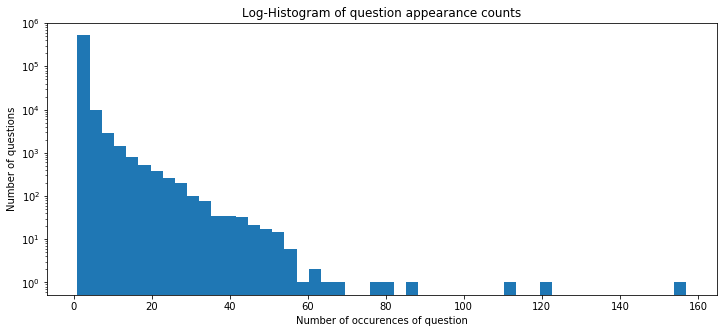

In [17]:
print('Duplicate pairs: {}%'.format(round(train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

Most questions only appear a few times, with very few questions appearing several times (and a few questions appearing many times). One question appears more than 160 times, but this is an outlier.

mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.63 max-train 1169.00 max-test 1176.00


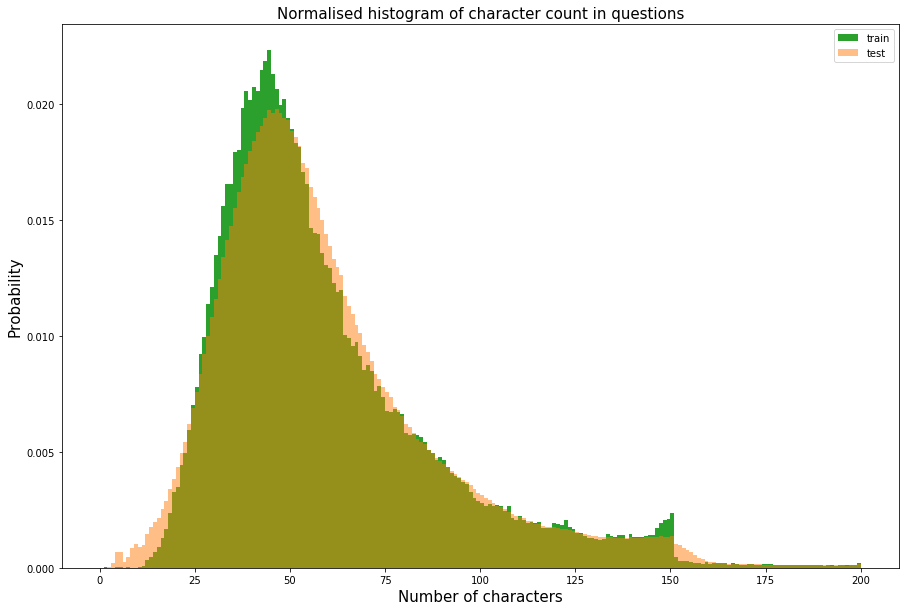

In [23]:
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
test_qs = pd.Series(test['question1'].tolist() + test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


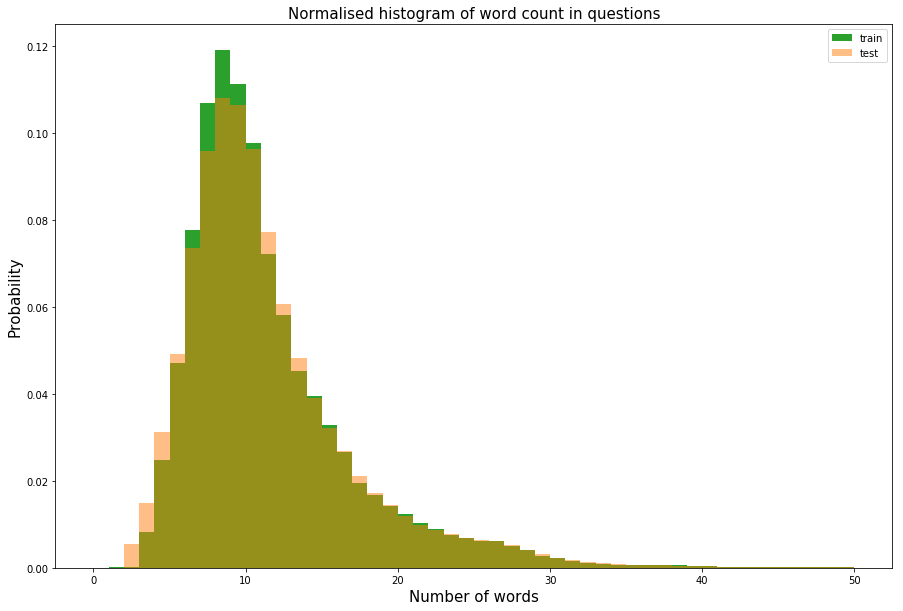

In [24]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

(-0.5, 1439.5, 1079.5, -0.5)

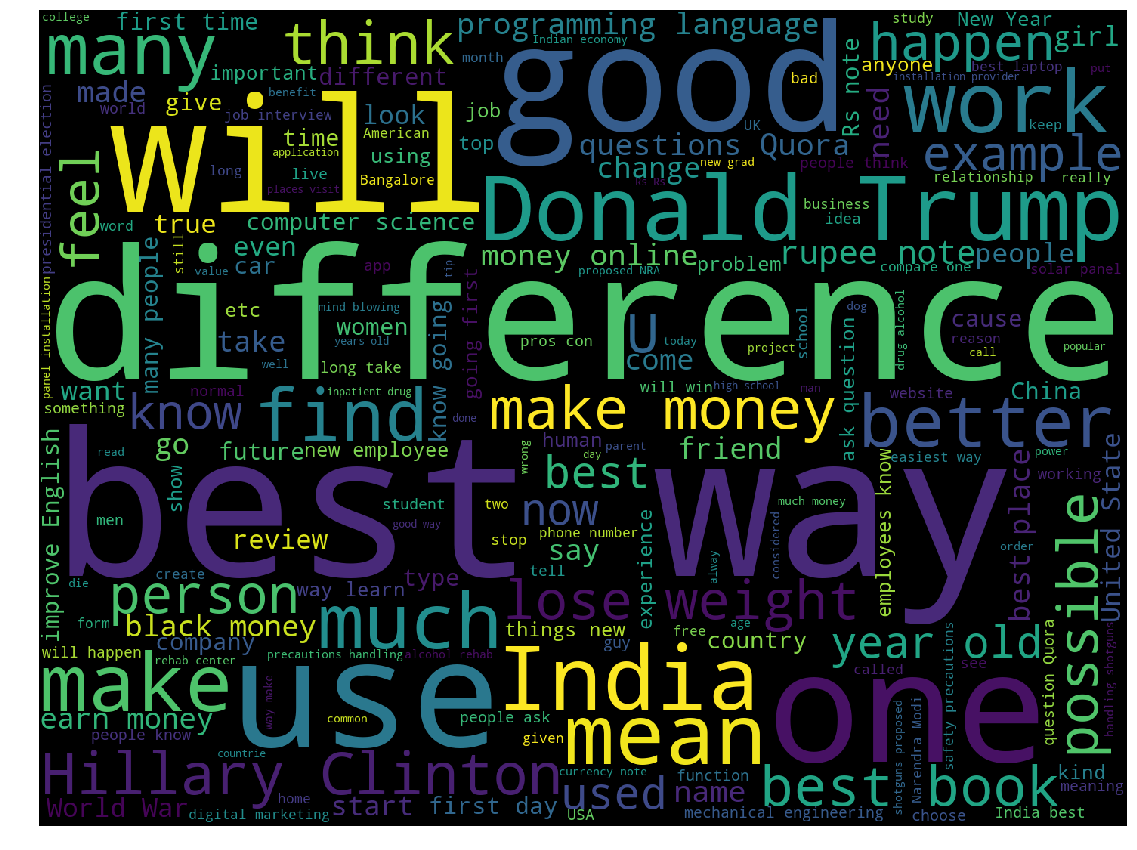

In [25]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

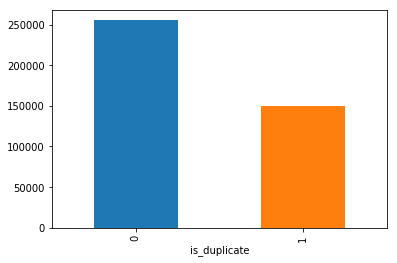

In [11]:
train.groupby("is_duplicate")['id'].count().plot.bar()

In [12]:
train.groupby("is_duplicate")['id'].count()

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

## 3. Semantic Analysis

qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 10))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

## 4. Preprocessing

## Data Cleaning

In [19]:
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

In [20]:
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

In [21]:
# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' is a placeholder for the [0, 0, ....0] embedding

word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)


In [22]:
questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [df_train, df_test]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

C:\Users\pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [23]:
# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

In [24]:
max_seq_length = max(df_train.question1.map(lambda x: len(x)).max(),
                     df_train.question2.map(lambda x: len(x)).max(),
                     df_test.question1.map(lambda x: len(x)).max(),
                     df_test.question2.map(lambda x: len(x)).max())

In [25]:
X = df_train[questions_cols]
y = df_train['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.3, random_state=42 )

In [26]:
# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': df_test.question1, 'right': df_test.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [27]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25


In [28]:
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [29]:
# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

In [30]:
# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

Instructions for updating:
Colocations handled automatically by placer.


In [31]:
# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

C:\Users\pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Instructions for updating:
Use tf.cast instead.
Train on 490 samples, validate on 210 samples
Epoch 1/25
490/490 [==============================] - ETA: 29s - loss: 0.3156 - acc: 0.60 - ETA: 13s - loss: 0.2585 - acc: 0.65 - ETA: 7s - loss: 0.2429 - acc: 0.6562 - ETA: 4s - loss: 0.2360 - acc: 0.664 - ETA: 2s - loss: 0.2433 - acc: 0.646 - ETA: 1s - loss: 0.2373 - acc: 0.651 - ETA: 0s - loss: 0.2447 - acc: 0.638 - 7s 14ms/step - loss: 0.2586 - acc: 0.6204 - val_loss: 0.2353 - val_acc: 0.6667
Epoch 2/25
490/490 [==============================] - ETA: 1s - loss: 0.2783 - acc: 0.625 - ETA: 1s - loss: 0.2536 - acc: 0.648 - ETA: 1s - loss: 0.2493 - acc: 0.640 - ETA: 1s - loss: 0.2492 - acc: 0.640 - ETA: 0s - loss: 0.2469 - acc: 0.637 - ETA: 0s - loss: 0.2391 - acc: 0.648 - ETA: 0s - loss: 0.2430 - acc: 0.636 - 2s 5ms/step - loss: 0.2450 - acc: 0.6347 - val_loss: 0.2308 - val_acc: 0.6810
Epoch 3/25
490/490 [==============================] - ETA: 1s - loss: 0.1950 - acc: 0.687 - ETA: 1s - loss: 

490/490 [==============================] - ETA: 1s - loss: 0.0884 - acc: 0.937 - ETA: 1s - loss: 0.0917 - acc: 0.921 - ETA: 1s - loss: 0.1001 - acc: 0.911 - ETA: 1s - loss: 0.0918 - acc: 0.921 - ETA: 0s - loss: 0.0925 - acc: 0.918 - ETA: 0s - loss: 0.0913 - acc: 0.921 - ETA: 0s - loss: 0.0921 - acc: 0.924 - 3s 6ms/step - loss: 0.0943 - acc: 0.9245 - val_loss: 0.2042 - val_acc: 0.7143
Epoch 21/25
490/490 [==============================] - ETA: 1s - loss: 0.0827 - acc: 0.968 - ETA: 1s - loss: 0.0941 - acc: 0.929 - ETA: 1s - loss: 0.1015 - acc: 0.916 - ETA: 0s - loss: 0.0958 - acc: 0.921 - ETA: 0s - loss: 0.0944 - acc: 0.925 - ETA: 0s - loss: 0.0921 - acc: 0.921 - ETA: 0s - loss: 0.0926 - acc: 0.928 - 2s 5ms/step - loss: 0.0908 - acc: 0.9286 - val_loss: 0.2039 - val_acc: 0.7143
Epoch 22/25
490/490 [==============================] - ETA: 1s - loss: 0.0668 - acc: 0.937 - ETA: 1s - loss: 0.0895 - acc: 0.921 - ETA: 1s - loss: 0.0891 - acc: 0.932 - ETA: 0s - loss: 0.0892 - acc: 0.933 - ETA: 0s

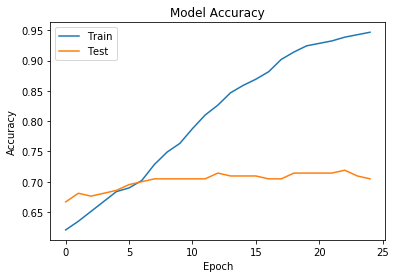

In [32]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

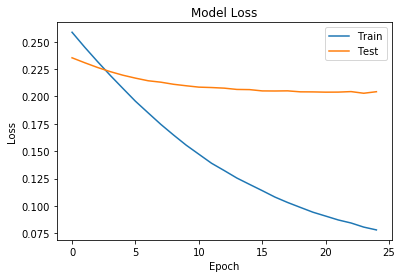

In [33]:
# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [34]:
# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adam(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

C:\Users\pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 490 samples, validate on 210 samples
Epoch 1/25
490/490 [==============================] - ETA: 26s - loss: 0.0530 - acc: 0.96 - ETA: 12s - loss: 0.0780 - acc: 0.94 - ETA: 6s - loss: 0.0863 - acc: 0.9375 - ETA: 4s - loss: 0.0780 - acc: 0.953 - ETA: 2s - loss: 0.0795 - acc: 0.950 - ETA: 1s - loss: 0.0784 - acc: 0.953 - ETA: 0s - loss: 0.0757 - acc: 0.953 - 7s 14ms/step - loss: 0.0765 - acc: 0.9490 - val_loss: 0.2052 - val_acc: 0.6952
Epoch 2/25
490/490 [==============================] - ETA: 1s - loss: 0.0848 - acc: 0.968 - ETA: 1s - loss: 0.0961 - acc: 0.929 - ETA: 1s - loss: 0.0819 - acc: 0.942 - ETA: 0s - loss: 0.0846 - acc: 0.937 - ETA: 0s - loss: 0.0801 - acc: 0.940 - ETA: 0s - loss: 0.0785 - acc: 0.947 - ETA: 0s - loss: 0.0738 - acc: 0.953 - 2s 5ms/step - loss: 0.0781 - acc: 0.9490 - val_loss: 0.2048 - val_acc: 0.7000
Epoch 3/25
490/490 [==============================] - ETA: 1s - loss: 0.0678 - acc: 0.968 - ETA: 1s - loss: 0.0689 - acc: 0.953 - ETA: 1s - loss: 0.0690 - a

490/490 [==============================] - ETA: 1s - loss: 0.0238 - acc: 1.000 - ETA: 1s - loss: 0.0372 - acc: 0.984 - ETA: 1s - loss: 0.0343 - acc: 0.979 - ETA: 0s - loss: 0.0309 - acc: 0.984 - ETA: 0s - loss: 0.0305 - acc: 0.984 - ETA: 0s - loss: 0.0327 - acc: 0.981 - ETA: 0s - loss: 0.0340 - acc: 0.977 - 2s 5ms/step - loss: 0.0335 - acc: 0.9796 - val_loss: 0.2156 - val_acc: 0.6857
Epoch 22/25
490/490 [==============================] - ETA: 1s - loss: 0.0398 - acc: 0.968 - ETA: 1s - loss: 0.0329 - acc: 0.976 - ETA: 1s - loss: 0.0294 - acc: 0.984 - ETA: 1s - loss: 0.0288 - acc: 0.984 - ETA: 0s - loss: 0.0272 - acc: 0.987 - ETA: 0s - loss: 0.0317 - acc: 0.984 - ETA: 0s - loss: 0.0315 - acc: 0.984 - 2s 5ms/step - loss: 0.0316 - acc: 0.9837 - val_loss: 0.2156 - val_acc: 0.6857
Epoch 23/25
490/490 [==============================] - ETA: 1s - loss: 0.0159 - acc: 1.000 - ETA: 1s - loss: 0.0278 - acc: 0.992 - ETA: 1s - loss: 0.0274 - acc: 0.989 - ETA: 0s - loss: 0.0327 - acc: 0.980 - ETA: 0s

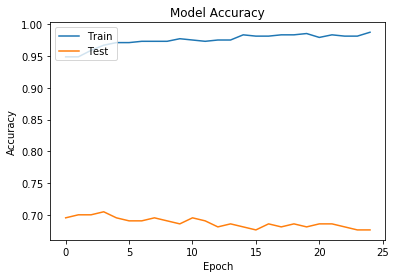

In [35]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

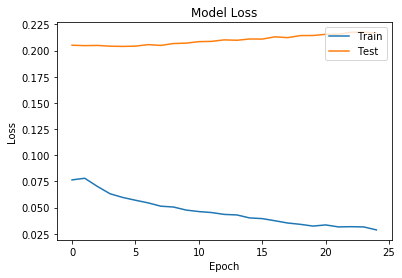

In [36]:
# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()